# HCV investigations

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from numpy import errstate,isneginf,array
import glob
import pandas as pd

### Copy the virus screening results

In [2]:
##%%bash
##mkdir RESULTS
##cp -r -p ../../../RNAVirusScanning_20210829/RESULTS_v1_USED/RESULTS_class_IV_genomes/ RESULTS/
##mv RESULTS/RESULTS_class_IV_genomes/ RESULTS/RESULTS_GroupIV_genomes/

### Copy the annotation and PWM files

In [3]:
##%%bash
##cp ../../../Figure2_code_from_Mari/annot_virus_host_GroupIV.txt RESULTS/
##cp ../../../Figure2_code_from_Mari/PWM_DB_encode_attract_rbpdb.txt RESULTS/

In [4]:
def collect_data(file_pattern, 
                 col_with_index, 
                 col_to_collect,
                 col_filter,
                 col_filter_equals="+"):
    """
    Collect a specific column from all result files and merge them based on a specific index column. 
    """
    
    file_list = sorted(glob.glob(file_pattern))

    df_list = []

    for curr_file in file_list:
        curr_df = pd.read_table(curr_file)
        curr_df = curr_df[curr_df[col_filter]==col_filter_equals]
        curr_df = curr_df.set_index(col_with_index)
        curr_df = curr_df.loc[:,[col_to_collect]]
        curr_file_id = str(curr_file.split("/")[3])
        curr_df.columns = [curr_file_id]
        df_list.append(curr_df)

    df_all = pd.concat(df_list, ignore_index=False, axis=1)

    return(df_all)

In [5]:
### Define Group and Strand for analysis
Group = "GroupIV" ## or classIV depending on the folder name
strand = "+"

### Load enrichment results and annotation for plotting

In [6]:
### PWM database
pwm_db=pd.read_table("RESULTS/PWM_DB_encode_attract_rbpdb.txt",index_col=0)

### Load annotation for selected group
annot=pd.read_table("RESULTS/annot_virus_host_"+Group+".txt",index_col=0)

In [7]:
### Load pvalues
pvalues = collect_data(file_pattern = "./RESULTS/RESULTS_"+Group+"_genomes/GCF_*/enrichment_shuf_1000_2_attract_rbpdb_encode_filtered_human_pwms.tsv", 
                        col_with_index='Matrix_id', 
                        col_to_collect='fdr',
                        col_filter='sense',
                        col_filter_equals=strand)
##pvalues

In [8]:
pvalues = pvalues.fillna(1)
pwm_pvalues=pd.merge(pwm_db,pvalues,how="right",left_index=True,right_index=True)
plot_pvalues=pwm_pvalues.iloc[:,3:].astype(float)
plot_pvalues.index=pwm_pvalues.Gene_Matrix
plot_pvalues = plot_pvalues.sort_values(by="Gene_Matrix")

plot_pvalues.to_csv("RESULTS/pvalues_"+Group+strand+".csv")

In [9]:
### Calculate foldchanges
num = collect_data(file_pattern = "./RESULTS/RESULTS_"+Group+"_genomes/GCF_*/enrichment_shuf_1000_2_attract_rbpdb_encode_filtered_human_pwms.tsv", 
                   col_with_index='Matrix_id', 
                   col_to_collect='num',
                   col_filter='sense',
                   col_filter_equals=strand)
##num

In [10]:
avg = collect_data(file_pattern = "./RESULTS/RESULTS_"+Group+"_genomes/GCF_*/enrichment_shuf_1000_2_attract_rbpdb_encode_filtered_human_pwms.tsv", 
                   col_with_index='Matrix_id', 
                   col_to_collect='avg',
                   col_filter='sense',
                   col_filter_equals=strand)
##avg

In [11]:
## Calculate the foldchanges
foldchanges = np.divide(num,avg)
foldchanges = foldchanges.fillna(1)
##foldchanges

In [12]:
### Merge foldchanges with RBP DB
foldchanges=pd.merge(pwm_db.iloc[:,0:1],foldchanges,how="outer",left_index=True,right_index=True)
foldchanges.index=foldchanges.Gene_Matrix
foldchanges=foldchanges.iloc[:,1:]
##foldchanges

In [13]:
### Calculate log of foldchanges
log2fc=np.log2(foldchanges)
log2fc[isneginf(log2fc)]=-10                      #### IF FOLDCHANGE IS ZERO, CHANGE LOG2FC TO SMALLEST NUMBER IN DATASET WITHOUT INFLATING THE NEGATIVE VALUES
log2fc = log2fc.fillna(0)                         #### CHANGE NAs to ZERO
##log2fc

In [14]:
# Store all the foldchanges
log2fc_all = log2fc.copy(deep=True)
# Set the none significant fold changes to zero
log2fc[plot_pvalues>0.05]=0

In [15]:
## Write the fold-changes to a file
log2fc=log2fc.loc[:,(log2fc.sum(axis=0) != 0)]    #### IGNORE GENOMES WITH NO RESULTS
log2fc.to_csv("RESULTS/logfc_"+Group+strand+".csv")

### Create plots

In [16]:
### Merge log of foldchanges with PWM DB
plot_df=pd.merge(annot,log2fc.transpose(),how="right",left_index=True,right_index=True)

### Order dataframe by "group_by"
plot_df = plot_df.sort_values(by="Family")

### Create colors for annotation in "group_by" (or column if "group_by" does not exist)
lut = dict(zip(plot_df["Family"].unique(), sns.hls_palette(len(plot_df["Family"].unique()))))
row_colors = plot_df["Family"].map(lut)

### Color columns per representatives
selected_columns = pwm_db[["Representative"]]
pwm_col = selected_columns.copy()
pwm_col.index=pwm_db.Gene_Matrix
lut2= dict(zip(pwm_col["Representative"].unique(),sns.hls_palette(len(pwm_col["Representative"].unique())))) 
col_colors = pwm_col["Representative"].map(lut2)

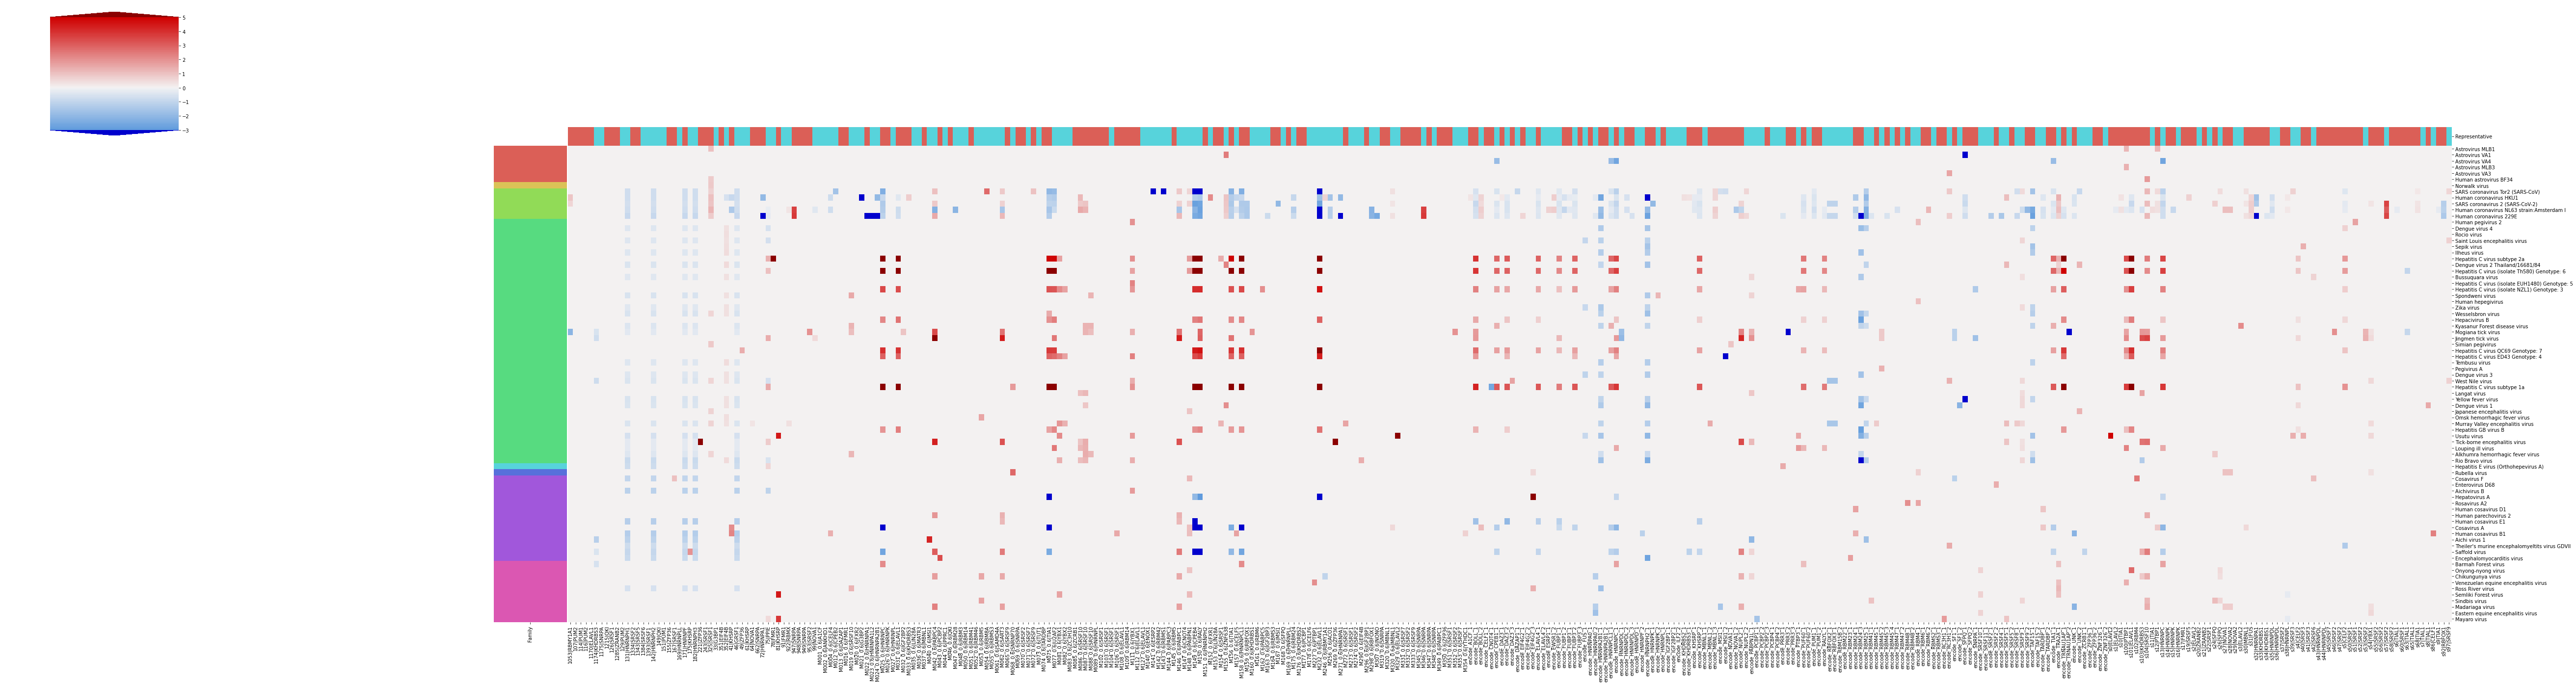

In [17]:
### Parameters for plot
cbar_kws = {'extend':'both'}    
cmap=plt.get_cmap(sns.diverging_palette(250, 15, l=40, s=150,as_cmap=True))
cmap.set_under('mediumblue')
cmap.set_over('darkred')
min=len(annot.columns)
max=len(plot_df.columns)    
height=len(plot_df)*0.25 ### height of figure depends on how many rows
width=max*0.2            ### width of figure depends on how many columns

### Create clustermap plot and save figure
sns_plot =sns.clustermap(plot_df.iloc[:,min:max], 
                         row_cluster=False, 
                         col_cluster=False, 
                         cmap=cmap,
                         cbar_kws=cbar_kws,
                         xticklabels=1,
                         yticklabels=plot_df["Species"],
                         row_colors=row_colors,
                         col_colors=col_colors,
                         figsize=(width,height),
                         center=0,vmin=-3, vmax=5 )
plt.show()  
sns_plot.savefig("RESULTS/"+Group+strand+".pdf")

In [18]:
# Get HCV virus genomes
subset_df = plot_df[plot_df["Species"].str.contains("Hepatitis C")]

/home/andreas/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


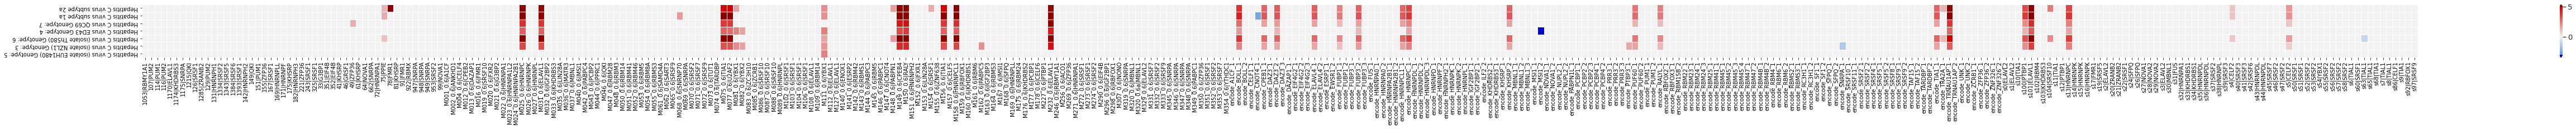

In [19]:
### Tried also heatmap for subset of corona and flavi viruses:
subset_df.sort_values(["Family","Species"],inplace=True,ascending=[False,False])                            #### Sort values

height=len(subset_df)*0.25                             # Height depends on size of matrix (rows)
width=len(subset_df.columns)*0.25                      # Width depends on size of matrix (columns)

fig, ax = plt.subplots(figsize=(width,height))         # Sample figsize in inches
sns.set(font_scale=1.2)

sns_col2_plot = sns.heatmap(subset_df.iloc[:,min:max],cmap=cmap,cbar_kws=cbar_kws,xticklabels=1,yticklabels=subset_df["Species"],center=0,vmin=-3, vmax=5,ax=ax,linewidth =0.5)
sns_col2_plot.set_yticklabels(sns_col2_plot.get_yticklabels(), rotation=180)
plt.savefig("RESULTS/HCV_all.pdf",bbox_inches = 'tight')       
plt.show()

## Filter out candidates that have no significant results

In [20]:
subset_df_filtered = subset_df.copy(deep=True)
nan_value = float("NaN")
subset_df_filtered.replace(0, nan_value, inplace=True)

In [21]:
subset_df_filtered.dropna(how='all', axis=1, inplace=True)

In [22]:
subset_df_filtered.replace(nan_value, 0, inplace=True)

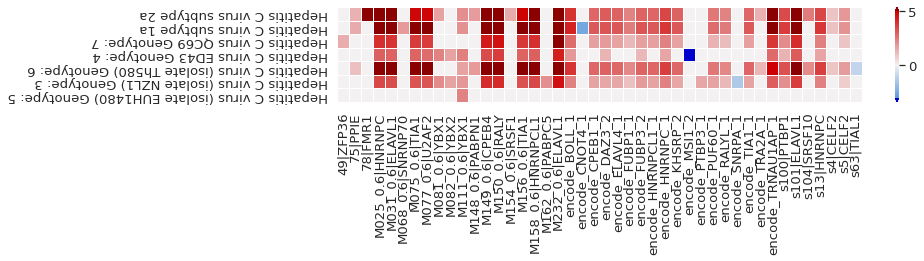

In [23]:
height=len(subset_df_filtered)*0.25                             # Height depends on size of matrix (rows)
width=len(subset_df_filtered.columns)*0.25                      # Width depends on size of matrix (columns)

fig, ax = plt.subplots(figsize=(width,height))         # Sample figsize in inches
sns.set(font_scale=1.2)

sns_col2_plot = sns.heatmap(subset_df_filtered.iloc[:,min:max],cmap=cmap,cbar_kws=cbar_kws,xticklabels=1,yticklabels=subset_df_filtered["Species"],center=0,vmin=-3, vmax=5,ax=ax,linewidth =0.5)
sns_col2_plot.set_yticklabels(sns_col2_plot.get_yticklabels(), rotation=180)
plt.savefig("RESULTS/HCV_significant.pdf",bbox_inches = 'tight')       
plt.show()

## Import requirements

In [24]:
# General imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# SMEAGOL imports
import smeagol.io, smeagol.models, smeagol.scan, smeagol.enrich, smeagol.visualize, smeagol.variant

2021-10-18 21:37:53.167166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 21:37:53.167234: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Check the HCV virus genomes for quality

In [25]:
import glob

HCV_complete_genomes = list()
HCV_not_complete_genomes = list()

for index in subset_df_filtered.index:    
    genome_pattern = "../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/" + index + "/" + index + "_*_genomic.fna.gz"
    genome_pathways = list(filter(lambda k: '_cds_' not in k, glob.glob(genome_pattern)))
    ##print(index)
    ##print(len(genome_pathways))
    ##print(genome_pathways)
    if len(genome_pathways) == 1:
        genome_path = genome_pathways[0]
        genome = smeagol.io.read_fasta(genome_path)
        ##print(genome)
        ##print(genome[0].description)
        ##print(len(genome[0].seq))

        if "complete genome" in genome[0].description:
            HCV_complete_genomes.append(index)
        else:
            HCV_not_complete_genomes.append(index)        
    else:
        print("ERROR: Multiple pathways found for genome: " + index)

Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_000871165.1/GCF_000871165.1_ViralProj20937_genomic.fna.gz
Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_000861845.1/GCF_000861845.1_ViralProj15432_genomic.fna.gz
Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_001712785.1/GCF_001712785.1_ViralProj339556_genomic.fna.gz
Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_000874265.1/GCF_000874265.1_ViralProj20933_genomic.fna.gz
Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_000872025.1/GCF_000872025.1_ViralProj20939_genomic.fna.gz
Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_000874285.1/GCF_000874285.1_ViralProj20941_genomic.fna.gz
Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_000873605.1/GCF_000873605.1_ViralProj20935_genomic.fna.gz


In [26]:
print("Complete genomes:")
print(HCV_complete_genomes)

print("NOT complete genomes:")
print(HCV_not_complete_genomes)

Complete genomes:
['GCF_000871165.1', 'GCF_000861845.1', 'GCF_001712785.1', 'GCF_000872025.1']
NOT complete genomes:
['GCF_000874265.1', 'GCF_000874285.1', 'GCF_000873605.1']


In [27]:
subset_df_filtered = subset_df_filtered.loc[HCV_complete_genomes,:]

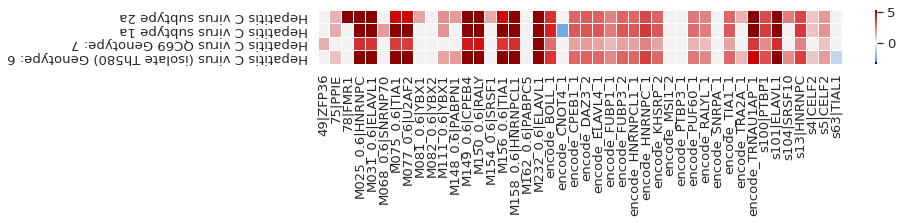

In [28]:
height=len(subset_df_filtered)*0.25                             # Height depends on size of matrix (rows)
width=len(subset_df_filtered.columns)*0.25                      # Width depends on size of matrix (columns)

fig, ax = plt.subplots(figsize=(width,height))         # Sample figsize in inches
sns.set(font_scale=1.2)

sns_col2_plot = sns.heatmap(subset_df_filtered.iloc[:,min:max],cmap=cmap,cbar_kws=cbar_kws,xticklabels=1,yticklabels=subset_df_filtered["Species"],center=0,vmin=-3, vmax=5,ax=ax,linewidth =0.5)
sns_col2_plot.set_yticklabels(sns_col2_plot.get_yticklabels(), rotation=180)
plt.savefig("RESULTS/HCV_significant_complete_genomes.pdf",bbox_inches = 'tight')       
plt.show()

## Select the data to plot

### Significant entries

In [29]:
genome_id = 'GCF_000861845.1'

In [30]:
Genotype1a_sig = subset_df_filtered.loc[[genome_id],:]

In [31]:
nan_value = float("NaN")
Genotype1a_sig.replace(0, nan_value, inplace=True)
Genotype1a_sig.dropna(how='all', axis=1, inplace=True)
Genotype1a_sig.replace(nan_value, 0, inplace=True)

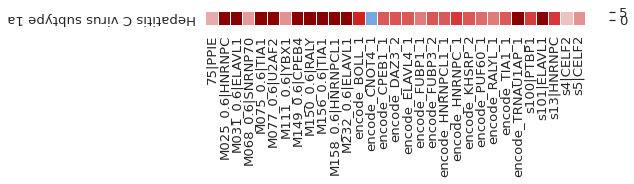

In [32]:
height=len(Genotype1a_sig)*0.25                             # Height depends on size of matrix (rows)
width=len(Genotype1a_sig.columns)*0.25                      # Width depends on size of matrix (columns)

fig, ax = plt.subplots(figsize=(width,height))         # Sample figsize in inches
sns.set(font_scale=1.2)

sns_col2_plot = sns.heatmap(Genotype1a_sig.iloc[:,min:max],cmap=cmap,cbar_kws=cbar_kws,xticklabels=1,yticklabels=Genotype1a_sig["Species"],center=0,vmin=-3, vmax=5,ax=ax,linewidth =0.5)
sns_col2_plot.set_yticklabels(sns_col2_plot.get_yticklabels(), rotation=180)
plt.savefig("RESULTS/HCV_significant_Genotype1a.pdf",bbox_inches = 'tight')       
plt.show()

In [33]:
data_sig = Genotype1a_sig.drop(['Family', 'Genus', 'Species'], axis=1)

### All entries

In [34]:
data_all = log2fc_all.transpose().loc[[genome_id],:]
nan_value = float("NaN")
data_all.replace(0, nan_value, inplace=True)
data_all.dropna(how='all', axis=1, inplace=True)
data_all.replace(nan_value, 0, inplace=True)
data_all

Gene_Matrix,1053|RBMY1A1,107|PUM2,114|PUM1,116|PUM2,1170|ELAVL1,1174|KHDRBS3,1175|SNRPA,1215|QKI,126|SRSF1,1285|ZRANB2,...,s60|SRSF1,s63|TIAL1,s65|TIAL1,s68|TIA1,s7|TIAL1,s8|TIAL1,s86|CELF1,s9|TIA1,s92|RBFOX1,s97|SRSF9
GCF_000861845.1,0.644157,-10.0,-10.0,-10.0,-0.461199,-0.400699,-1.699552,0.039192,-0.317672,-1.086784,...,1.16273,-0.123761,-10.0,-0.037724,-0.772308,-0.759582,-0.27262,-0.373061,-0.53655,0.519513


In [35]:
import math
xmin = math.floor(data_all.values[0].min())
xmax = math.ceil(data_all.values[0].max())
print(xmin)
print(xmax)

-10
7


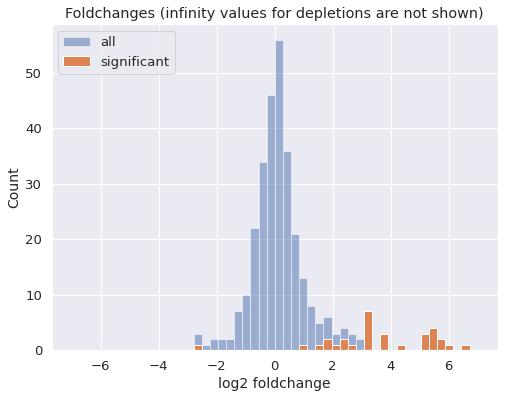

In [36]:
## HISTOGRAM for HCV Figure (a)
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(data_all.values[0], 
         range=[-1*xmax, xmax],
         bins=50, 
         alpha = 0.5, 
         label='all')
plt.hist(data_sig.values[0], 
         range=[-1*xmax, xmax],
         bins=50, 
         alpha = 1.0, 
         label='significant')
plt.xlabel("log2 foldchange", size=14)
plt.ylabel("Count", size=14)
plt.title("Foldchanges (infinity values for depletions are not shown)")
plt.legend(loc='upper left')
plt.savefig("RESULTS/HCV_foldchanges_hist.pdf")
plt.show()

In [37]:
list(data_sig.columns)

['75|PPIE',
 'M025_0.6|HNRNPC',
 'M031_0.6|ELAVL1',
 'M068_0.6|SNRNP70',
 'M075_0.6|TIA1',
 'M077_0.6|U2AF2',
 'M111_0.6|YBX1',
 'M149_0.6|CPEB4',
 'M150_0.6|RALY',
 'M156_0.6|TIA1',
 'M158_0.6|HNRNPCL1',
 'M232_0.6|ELAVL1',
 'encode_BOLL_1',
 'encode_CNOT4_1',
 'encode_CPEB1_1',
 'encode_DAZ3_2',
 'encode_ELAVL4_1',
 'encode_FUBP1_1',
 'encode_FUBP3_2',
 'encode_HNRNPCL1_1',
 'encode_HNRNPC_1',
 'encode_KHSRP_2',
 'encode_PUF60_1',
 'encode_RALYL_1',
 'encode_TIA1_1',
 'encode_TRNAU1AP_1',
 's100|PTBP1',
 's101|ELAVL1',
 's13|HNRNPC',
 's4|CELF2',
 's5|CELF2']

In [72]:
data_sig.transpose()

,GCF_000861845.1
75|PPIE,1.453217
M025_0.6|HNRNPC,5.517919
M031_0.6|ELAVL1,5.542398
M068_0.6|SNRNP70,1.798994
M075_0.6|TIA1,5.127841
M077_0.6|U2AF2,5.268952
M111_0.6|YBX1,2.014176
M149_0.6|CPEB4,5.870316
M150_0.6|RALY,6.113192
M156_0.6|TIA1,5.279471


In [38]:
list(data_sig[data_sig > 5].dropna(axis=1))

['M025_0.6|HNRNPC',
 'M031_0.6|ELAVL1',
 'M075_0.6|TIA1',
 'M077_0.6|U2AF2',
 'M149_0.6|CPEB4',
 'M150_0.6|RALY',
 'M156_0.6|TIA1',
 'M158_0.6|HNRNPCL1',
 'M232_0.6|ELAVL1',
 'encode_TRNAU1AP_1',
 's101|ELAVL1']

# Get the p-values for the HCV Genotype 1a genome

In [41]:
Genotype1a_pvalues = plot_pvalues.loc[:,[genome_id]]
Genotype1a_pvalues

,GCF_000861845.1
Gene_Matrix,
1053|RBMY1A1,0.485227
107|PUM2,1.000000
114|PUM1,1.000000
116|PUM2,1.000000
1170|ELAVL1,0.338708
...,...
s86|CELF1,1.000000
s8|TIAL1,1.000000
s92|RBFOX1,1.000000


In [52]:
### Merge foldchanges with RBP DB
HCV_allRBPs_Names = pd.merge(pwm_db,Genotype1a_pvalues,how="outer", left_on='Gene_Matrix', right_on='Gene_Matrix')
HCV_allRBPs_Names.index = HCV_allRBPs_Names.Gene_Matrix
HCV_allRBPs_Names.drop(columns=['source','Representative'])
HCV_allRBPs_Names

,Gene_Matrix,Gene_name,source,Representative,GCF_000861845.1
Gene_Matrix,,,,,
1053|RBMY1A1,1053|RBMY1A1,RBMY1A1,RBPDB,False,4.852271e-01
107|PUM2,107|PUM2,PUM2,Attract,False,1.000000e+00
114|PUM1,114|PUM1,PUM1,Attract,False,1.000000e+00
116|PUM2,116|PUM2,PUM2,Attract,False,1.000000e+00
1170|ELAVL1,1170|ELAVL1,ELAVL1,RBPDB,False,3.387084e-01
1215|QKI,1215|QKI,QKI,RBPDB,False,1.000000e+00
126|SRSF1,126|SRSF1,SRSF1,Attract,False,7.966341e-01
1285|ZRANB2,1285|ZRANB2,ZRANB2,RBPDB,False,1.000000e+00
1334|SRSF2,1334|SRSF2,SRSF2,Attract,False,1.000000e+00


In [57]:
# Make sure we take the absolute value
HCV_allRBPs_Names[genome_id] = HCV_allRBPs_Names[genome_id] # .abs()
HCV_allRBPs_Names

,Gene_Matrix,Gene_name,source,Representative,GCF_000861845.1
Gene_Matrix,,,,,
1053|RBMY1A1,1053|RBMY1A1,RBMY1A1,RBPDB,False,4.852271e-01
107|PUM2,107|PUM2,PUM2,Attract,False,1.000000e+00
114|PUM1,114|PUM1,PUM1,Attract,False,1.000000e+00
116|PUM2,116|PUM2,PUM2,Attract,False,1.000000e+00
1170|ELAVL1,1170|ELAVL1,ELAVL1,RBPDB,False,3.387084e-01
1215|QKI,1215|QKI,QKI,RBPDB,False,1.000000e+00
126|SRSF1,126|SRSF1,SRSF1,Attract,False,7.966341e-01
1285|ZRANB2,1285|ZRANB2,ZRANB2,RBPDB,False,1.000000e+00
1334|SRSF2,1334|SRSF2,SRSF2,Attract,False,1.000000e+00


In [61]:
# Aggregate by RBP 
HCV_allRBPs = HCV_allRBPs_Names.groupby(['Gene_name'], as_index=True)['GCF_000861845.1'].min().to_frame()
HCV_allRBPs

,GCF_000861845.1
Gene_name,
A1CF,8.732927e-01
ACO1,4.878808e-01
ANKHD1,1.000000e+00
BOLL,1.220809e-69
CELF1,8.939858e-01
CELF2,6.980410e-27
CELF4,1.000000e+00
CELF5,1.000000e+00
CELF6,1.000000e+00


# Read in experimental validations

In [59]:
# Read in the files currated here
# cp -r -p /home/andreas/bc2_mountpoints/group_dir/gruberan/working_dir/paper_RBPs/viruses/04_HCV_high_throughput_studies/ .
experiments = pd.read_table("../DATA/ENRICHMENT_VALIDATION/HCV_experiments.tsv", index_col=9)

In [60]:
# Select specific columns
experiments_filtered = experiments.copy(deep=True)
experiments_filtered = experiments_filtered[['EntrezId','nr_experiments']]
experiments_filtered

,EntrezId,nr_experiments
V1,,
PCBP1,5093,4
PTBP1,5725,4
DHX9,1660,3
ELAVL1,1994,3
HNRNPL,3191,3
IRF9,10379,2
IGF2BP3,10643,2
DDX3X,1654,2
XRCC6,2547,2


# Merge experimental validations to pvalues

In [62]:
# Map them together
CTdf = pd.merge(HCV_allRBPs, 
                experiments_filtered, 
                how="left",
                left_index=True,
                right_index=True)
pd.set_option('display.max_rows', None)
print(CTdf)

           GCF_000861845.1  EntrezId  nr_experiments
A1CF          8.732927e-01       NaN             NaN
ACO1          4.878808e-01       NaN             NaN
ANKHD1        1.000000e+00   54882.0             1.0
BOLL          1.220809e-69       NaN             NaN
CELF1         8.939858e-01       NaN             NaN
CELF2         6.980410e-27       NaN             NaN
CELF4         1.000000e+00       NaN             NaN
CELF5         1.000000e+00       NaN             NaN
CELF6         1.000000e+00       NaN             NaN
CNOT4         2.014991e-02       NaN             NaN
CPEB1         1.221037e-46       NaN             NaN
CPEB2         3.198252e-01       NaN             NaN
CPEB4         2.863323e-99       NaN             NaN
DAZ3          2.149807e-47       NaN             NaN
DAZAP1        6.367030e-01       NaN             NaN
EIF4B         5.602388e-01       NaN             NaN
EIF4G2        1.982240e-01       NaN             NaN
ELAVL1       6.087592e-109    1994.0          

In [69]:
# Sort by p-value
CTdf_top = CTdf.sort_values(by=['GCF_000861845.1'], ascending=True)
CTdf_top.head(n=10)

,GCF_000861845.1,EntrezId,nr_experiments
ELAVL1,6.087592e-109,1994.0,3.0
RALY,2.022776e-104,NaN,NaN
CPEB4,2.863323e-99,NaN,NaN
HNRNPCL1,8.635365e-92,NaN,NaN
HNRNPC,8.635365e-92,3183.0,2.0
U2AF2,5.838559e-90,NaN,NaN
TIA1,5.600706e-88,7072.0,1.0
TRNAU1AP,1.098494e-83,NaN,NaN
BOLL,1.220809e-69,NaN,NaN
PTBP1,4.288267e-68,5725.0,4.0


# Get the foldchanges for the HCV Genotype 1a genome

In [77]:
Genotype1a_fc = data_sig.transpose().loc[:,[genome_id]]

,GCF_000861845.1
75|PPIE,1.453217
M025_0.6|HNRNPC,5.517919
M031_0.6|ELAVL1,5.542398
M068_0.6|SNRNP70,1.798994
M075_0.6|TIA1,5.127841
M077_0.6|U2AF2,5.268952
M111_0.6|YBX1,2.014176
M149_0.6|CPEB4,5.870316
M150_0.6|RALY,6.113192
M156_0.6|TIA1,5.279471


In [80]:
### Merge foldchanges with RBP DB
HCV_allRBPs_Names = pd.merge(pwm_db,Genotype1a_fc,how="outer", left_on='Gene_Matrix', right_index=True)
HCV_allRBPs_Names.index = HCV_allRBPs_Names.Gene_Matrix
HCV_allRBPs_Names.drop(columns=['source','Representative'])
HCV_allRBPs_Names

,Gene_Matrix,Gene_name,source,Representative,GCF_000861845.1
Gene_Matrix,,,,,
1053|RBMY1A1,1053|RBMY1A1,RBMY1A1,RBPDB,False,NaN
107|PUM2,107|PUM2,PUM2,Attract,False,NaN
114|PUM1,114|PUM1,PUM1,Attract,False,NaN
116|PUM2,116|PUM2,PUM2,Attract,False,NaN
1170|ELAVL1,1170|ELAVL1,ELAVL1,RBPDB,False,NaN
1215|QKI,1215|QKI,QKI,RBPDB,False,NaN
126|SRSF1,126|SRSF1,SRSF1,Attract,False,NaN
1285|ZRANB2,1285|ZRANB2,ZRANB2,RBPDB,False,NaN
1334|SRSF2,1334|SRSF2,SRSF2,Attract,False,NaN


In [81]:
# Make sure we take the absolute value
HCV_allRBPs_Names[genome_id] = HCV_allRBPs_Names[genome_id].abs()
HCV_allRBPs_Names

,Gene_Matrix,Gene_name,source,Representative,GCF_000861845.1
Gene_Matrix,,,,,
1053|RBMY1A1,1053|RBMY1A1,RBMY1A1,RBPDB,False,NaN
107|PUM2,107|PUM2,PUM2,Attract,False,NaN
114|PUM1,114|PUM1,PUM1,Attract,False,NaN
116|PUM2,116|PUM2,PUM2,Attract,False,NaN
1170|ELAVL1,1170|ELAVL1,ELAVL1,RBPDB,False,NaN
1215|QKI,1215|QKI,QKI,RBPDB,False,NaN
126|SRSF1,126|SRSF1,SRSF1,Attract,False,NaN
1285|ZRANB2,1285|ZRANB2,ZRANB2,RBPDB,False,NaN
1334|SRSF2,1334|SRSF2,SRSF2,Attract,False,NaN


In [82]:
# Aggregate by RBP 
HCV_allRBPs = HCV_allRBPs_Names.groupby(['Gene_name'], as_index=True)['GCF_000861845.1'].max().to_frame()
HCV_allRBPs

,GCF_000861845.1
Gene_name,
A1CF,NaN
ACO1,NaN
ANKHD1,NaN
BOLL,4.266750
CELF1,NaN
CELF2,1.959292
CELF4,NaN
CELF5,NaN
CELF6,NaN


# Merge experimental validations with foldchanges

In [83]:
# Map them together
CTdf = pd.merge(HCV_allRBPs, 
                experiments_filtered, 
                how="left",
                left_index=True,
                right_index=True)
pd.set_option('display.max_rows', None)
print(CTdf)

           GCF_000861845.1  EntrezId  nr_experiments
A1CF                   NaN       NaN             NaN
ACO1                   NaN       NaN             NaN
ANKHD1                 NaN   54882.0             1.0
BOLL              4.266750       NaN             NaN
CELF1                  NaN       NaN             NaN
CELF2             1.959292       NaN             NaN
CELF4                  NaN       NaN             NaN
CELF5                  NaN       NaN             NaN
CELF6                  NaN       NaN             NaN
CNOT4             2.536302       NaN             NaN
CPEB1             3.129503       NaN             NaN
CPEB2                  NaN       NaN             NaN
CPEB4             5.870316       NaN             NaN
DAZ3              3.195314       NaN             NaN
DAZAP1                 NaN       NaN             NaN
EIF4B                  NaN       NaN             NaN
EIF4G2                 NaN       NaN             NaN
ELAVL1            6.617309    1994.0          

In [86]:
# Sort by p-value
CTdf_top = CTdf.sort_values(by=['GCF_000861845.1'], ascending=False)
CTdf_top.head(n=20)

,GCF_000861845.1,EntrezId,nr_experiments
ELAVL1,6.617309,1994.0,3.0
RALY,6.113192,NaN,NaN
CPEB4,5.870316,NaN,NaN
HNRNPCL1,5.517919,NaN,NaN
HNRNPC,5.517919,3183.0,2.0
TRNAU1AP,5.351074,NaN,NaN
TIA1,5.279471,7072.0,1.0
U2AF2,5.268952,NaN,NaN
BOLL,4.266750,NaN,NaN
PTBP1,3.738414,5725.0,4.0


# Scan the HCV genome

In [87]:
# HCV
genome_sense = '+'
genome_file = '../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/' \
            + genome_id + '/' + genome_id + '_ViralProj15432_genomic.fna.gz'

In [88]:
%%time
genome = smeagol.io.read_fasta(genome_file)
genome

Read 1 records from ../DATA/Genomes/Genomes/IV/Monopartite/Flaviviridae/GCF_000861845.1/GCF_000861845.1_ViralProj15432_genomic.fna.gz
CPU times: user 3.06 ms, sys: 0 ns, total: 3.06 ms
Wall time: 2.73 ms


[SeqRecord(seq=Seq('GCCAGCCCCCTGATGGGGGCGACACTCCACCATGAATCACTCCCCTGTGAGGAA...TGT'), id='NC_004102.1', name='NC_004102.1', description='NC_004102.1 Hepatitis C virus genotype 1, complete genome', dbxrefs=[])]

In [89]:
pwm_file = '../DATA/PWMs/attract_rbpdb_encode_filtered_human_pwms.h5'
pwms = pd.read_hdf(pwm_file, key="data")
pwms.head()

,Matrix_id,Gene_name,Gene_id,Experiment_description,source,freqs,probs,len,entropy,weights
0,s36,HNRNPDL,ENSG00000152795,SELEX,Attract,NaN,"[[0.8443251, 0.00076687115, 0.1541411, 0.00076...",7,8.475865,"[[1.7558706, -8.348728, -0.69767654, -8.348728..."
1,M269_0.6,ZFP36,ENSG00000128016,SELEX,Attract,NaN,"[[0.97, 0.01, 0.01, 0.01], [0.97, 0.01, 0.01, ...",11,6.236948,"[[1.9560567, -4.643856, -4.643856, -4.643856],..."
2,M157_0.6,CELF5,ENSG00000161082,RNAcompete,Attract,NaN,"[[0.08396381, 0.08396381, 0.08396381, 0.748108...",7,5.910135,"[[-1.5740886, -1.5740886, -1.5740886, 1.581319..."
3,M042_0.6,PABPC4,ENSG00000090621,RNAcompete,Attract,NaN,"[[0.77843714, 0.10307988, 0.11052549, 0.007957...",7,5.255954,"[[1.6386524, -1.2781653, -1.177549, -4.9734616..."
4,M062_0.6,SART3,ENSG00000075856,RNAcompete,Attract,NaN,"[[0.7570201, 0.080993265, 0.080993265, 0.08099...",7,5.665008,"[[1.5984036, -1.6260543, -1.6260543, -1.626054..."


In [90]:
pwms[pwms.Matrix_id=='M232_0.6']

,Matrix_id,Gene_name,Gene_id,Experiment_description,source,freqs,probs,len,entropy,weights
75,M232_0.6,ELAVL1,ENSG00000066044,RNAcompete,Attract,NaN,"[[0.009889737, 0.11367061, 0.10729123, 0.76914...",7,5.75239,"[[-4.659852, -1.1370689, -1.2203959, 1.621334]..."


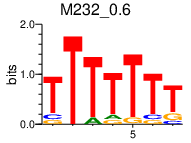

In [91]:
smeagol.visualize.plot_pwm(pwms, Matrix_id='M232_0.6')

In [92]:
model = smeagol.models.PWMModel(pwms)

2021-10-19 00:34:37.914698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-19 00:34:37.915128: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-19 00:34:37.915273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ag-Inspiron-7370): /proc/driver/nvidia/version does not exist
2021-10-19 00:34:37.917706: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [93]:
sites = smeagol.scan.scan_sequences(genome, model, threshold=0.7, sense=genome_sense, 
                                    rcomp='both', outputs=['sites'], score=True)

2021-10-19 00:34:40.855755: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-19 00:34:40.885702: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1999965000 Hz
2021-10-19 00:34:41.046314: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 27934816 exceeds 10% of free system memory.


In [94]:
sites = sites['sites']
sites.head()

,id,name,sense,start,Matrix_id,width,end,score,max_score,frac_score
0,NC_004102.1,NC_004102.1,+,1,64,4,5,5.393495,5.393495,1.000000
1,NC_004102.1,NC_004102.1,+,1,M026_0.6,7,8,8.142756,10.667440,0.763328
2,NC_004102.1,NC_004102.1,+,1,922,4,5,6.148969,6.148969,1.000000
3,NC_004102.1,NC_004102.1,+,4,encode_PCBP1_1,5,9,8.331131,8.331131,1.000000
4,NC_004102.1,NC_004102.1,+,4,encode_SRSF5_2,5,9,9.015263,9.015263,1.000000


In [95]:
simN=100 # Number of times to shuffle
simK=2 # k-mer length to keep fixed

In [96]:
%time
threshold_binned_results = smeagol.enrich.examine_thresholds(genome, model, simN, simK, rcomp='none', sense=genome_sense, 
                                              min_threshold=0.5, verbose=True, combine_seqs=True)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.63 µs
Shuffled 1 sequence(s) 100 times while conserving k-mer frequency for k = 2.


2021-10-19 00:34:50.427597: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 446957056 exceeds 10% of free system memory.
2021-10-19 00:34:50.615496: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 446957056 exceeds 10% of free system memory.
2021-10-19 00:34:50.780959: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 446957056 exceeds 10% of free system memory.
2021-10-19 00:34:51.001718: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 55869632 exceeds 10% of free system memory.


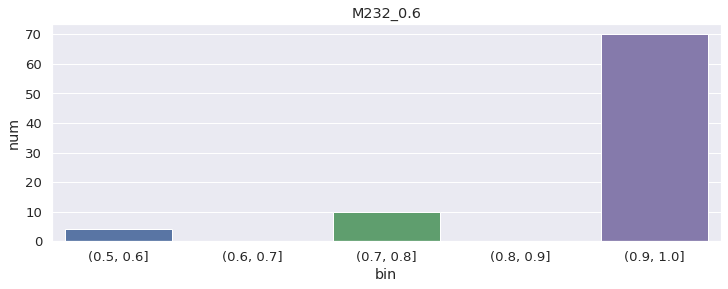

In [97]:
smeagol.visualize.plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='M232_0.6', sense ='+')

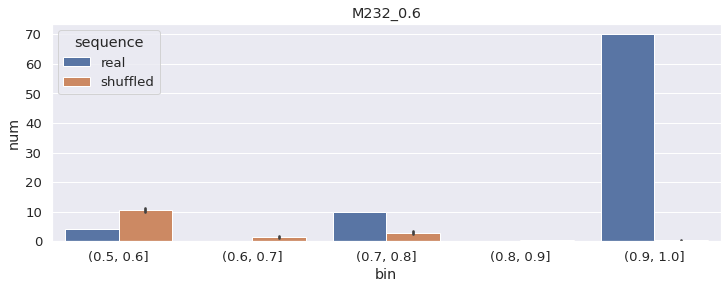

In [98]:
smeagol.visualize.plot_binned_count_dist(threshold_binned_results['real_binned'], Matrix_id='M232_0.6', 
                                         sense ='+', shuf_preds=threshold_binned_results['shuf_binned'])

In [99]:
simN=250
simK=2
rcomp='both'
threshold=0.8

In [102]:
enrichment_result = smeagol.enrich.enrich_in_genome(genome, model, simN=simN, simK=simK, rcomp=rcomp, 
                                                    sense=genome_sense, threshold=threshold, 
                                                    combine_seqs=True, background='binomial')

Shuffled 1 sequence(s) 250 times while conserving k-mer frequency for k = 2.


2021-10-19 00:40:55.827246: W tensorflow/core/framework/op_kernel.cc:1767] OP_REQUIRES failed at conv_ops.cc:662 : Resource exhausted: OOM when allocating tensor with shape[32,1,9646,362] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu


ResourceExhaustedError:  OOM when allocating tensor with shape[32,1,9646,362] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node pwm_model/conv1d/conv1d (defined at home/andreas/miniconda3/lib/python3.7/site-packages/smeagol/models.py:60) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_150]

Function call stack:
predict_function


In [ ]:
real_sites = enrichment_result['real_sites']
real_sites.head()

In [ ]:
real_counts = enrichment_result['real_counts']
real_counts.head()

In [ ]:
plt.figure(figsize=(12, 3))
sns.histplot(data=real_counts, x='num', hue='sense', bins='auto')

In [ ]:
shuf_counts = enrichment_result['shuf_counts']
shuf_counts.head()

In [ ]:
shuf_stats = enrichment_result['shuf_stats']
shuf_stats.head()

In [ ]:
enr = enrichment_result['enrichment']
enr.head()

In [ ]:
enr_pos = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='+')].reset_index(drop=True) # enriched on + strand
enr_neg = enr[(enr.fdr<0.05) & (enr.num > enr.avg) & (enr.sense=='-')].reset_index(drop=True) # enriched on - strand
dep_pos = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='+')].reset_index(drop=True) # depleted on + strand
dep_neg = enr[(enr.fdr<0.05) & (enr.num < enr.avg) & (enr.sense=='-')].reset_index(drop=True) # depleted on - strand

print(len(enr_pos))
print(len(enr_neg))
print(len(dep_pos))
print(len(dep_neg))

In [ ]:
window_count = smeagol.scan.count_in_sliding_windows(real_sites[real_sites.sense=='+'], 
                                                     genome, 'M232_0.6', 1000)
window_count.head()

In [ ]:
smeagol.visualize.sliding_window_count_plot(window_count, cols=1, title=('M232_0.6' + ' counts per genome window'))

In [ ]:
smeagol.visualize.plot_background(enrichment_result, enr_pos.Matrix_id, sense='+', figsize=(16,5), ncols=3)

# Enrichment in sliding windows

In [ ]:
r = smeagol.enrich.enrich_in_sliding_windows(real_sites[real_sites.sense=="+"], 
                                             genome, 'M232_0.6', 500)
r.head()

In [ ]:
r[(r.padj<0.05) & (r.odds > 1)]

In [ ]:
r[(r.padj<0.05) & (r.odds < 1)]

In [ ]:
pwm = 'M232_0.6'

In [ ]:
r['window'] = r.index
r['sig'] = r.padj<0.05
r['window_name'] = r.apply(lambda row: row.id + ':' + str(row.start) + '-' + str(row.end), axis=1)
smeagol.visualize.sliding_window_enrichment_plot(sliding_window_df=r, 
                                                 x_var='window', 
                                                 y_var='count', 
                                                 xticklabels='window_name', title=(pwm + ' counts per genome window'),
                                                 #fig_size=(12,5),
                                                 file_path=('RESULTS/' + genome_id + '_' + pwm + '.png'))

# Below code that was not used for reporting

In [ ]:
CTdf['PWM_sig'] = CTdf[genome_id] > 0
CTdf

In [ ]:
CTdf['exp_val'] = CTdf['nr_experiments'] >= 2
CTdf

In [ ]:
ct = pd.crosstab(index=CTdf['PWM_sig'], columns=CTdf['exp_val'])
ct

In [ ]:
from scipy.stats import fisher_exact
oddsr, p = fisher_exact(ct, alternative='two-sided')
p

In [ ]:
from scipy.stats import fisher_exact

for threshold in [1,2,3]:
    CTdf['exp_val'] = CTdf['nr_experiments'] >= threshold
    ct = pd.crosstab(index=CTdf['PWM_sig'], columns=CTdf['exp_val'])
    print(ct)
    oddsr, p = fisher_exact(ct, alternative='two-sided')
    print("p-value for RBPs with >= " + str(threshold) + " experimental validations: " + str(p))

In [ ]:
threshold = 1
CTdf['exp_val'] = CTdf['nr_experiments'] >= threshold
CTdf.fillna(0, inplace=True)
CTdf_top = CTdf.sort_values(by=[genome_id], ascending=False)
CTdf_test = CTdf_top.head(n=10)
CTdf_test

In [ ]:
ct = pd.crosstab(index=CTdf_test['PWM_sig'], columns=CTdf_test['exp_val'])
print(ct)

In [ ]:
# Check the other way around
CTdf_test = CTdf[(CTdf['nr_experiments'] >= 2)]
print(CTdf_test.shape)
CTdf_test